<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningRNN/blob/main/SeriesTemporaisvariasfeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Séries Temporais

## Setup

In [51]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Dataset

In [52]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Rearanjando os dados de min e horas

In [53]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Visualizando Dataset:

In [54]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Evolução das features ao longo do tempo. 

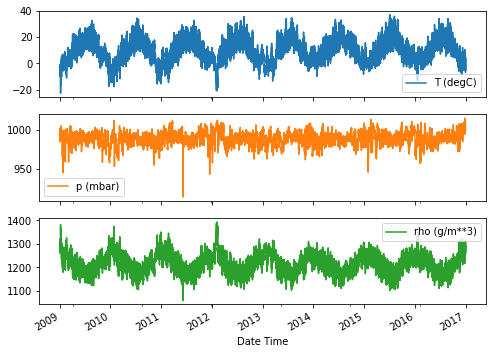

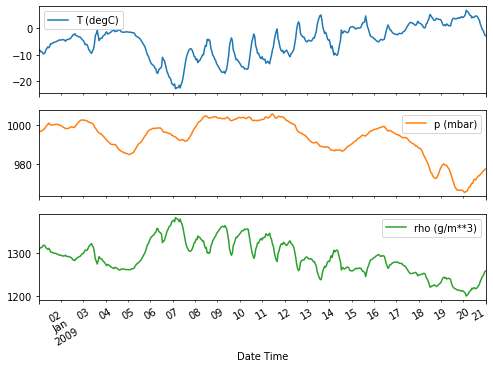

In [55]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspecionar e limpar os dados

estatísticas do conjunto de dados:

In [56]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Velocidade do vento

Uma coisa que deve se destacar é o valor mínimo da velocidade do vento, wv (m / s) e max. colunas wv (m / s). Provavelmente, este -9999 está errado. Há uma coluna de direção do vento separada, então a velocidade deve ser> = 0. Substitua por zeros:


In [57]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Antes de mergulhar na construção de um modelo, é importante entender seus dados e certificar-se de que você está transmitindo os dados formatados apropriadamente ao modelo.

#### Vento
A última coluna dos dados, `wd (deg)`, fornece a direção do vento em unidades de graus. Os ângulos não são boas entradas de modelo, 360 ° e 0 ° devem estar próximos um do outro e envolver suavemente. A direção não deve importar se o vento não estiver soprando.

No momento, a distribuição dos dados do vento se parece com esta:

Text(0, 0.5, 'Velocidade do Vento [m/s]')

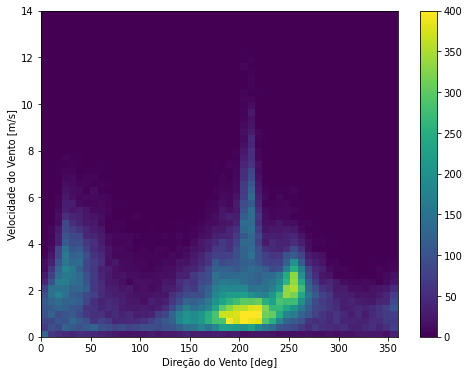

In [58]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Direção do Vento [deg]')
plt.ylabel('Velocidade do Vento [m/s]')

Isso será mais fácil para o modelo interpretar se você converter as colunas de direção e velocidade do vento em um vetor de vento:

In [59]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

A distribuição dos vetores de vento é muito mais simples para o modelo interpretar corretamente.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

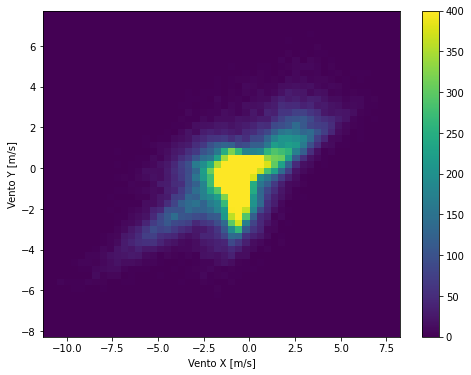

In [60]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Vento X [m/s]')
plt.ylabel('Vento Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Tempo

Da mesma forma, a coluna Data e hora é muito útil, mas não neste formato de string. Comece convertendo para segundos:

In [61]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Semelhante à direção do vento, o tempo em segundos não é uma entrada de modelo útil. Por ser um dado meteorológico, ele tem uma periodicidade diária e anual clara. Existem muitas maneiras de lidar com a periodicidade.

Uma abordagem simples para convertê-lo em um sinal utilizável é usar sen e cos para converter a hora para limpar os sinais de "Hora do dia" e "Hora do ano":

In [62]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

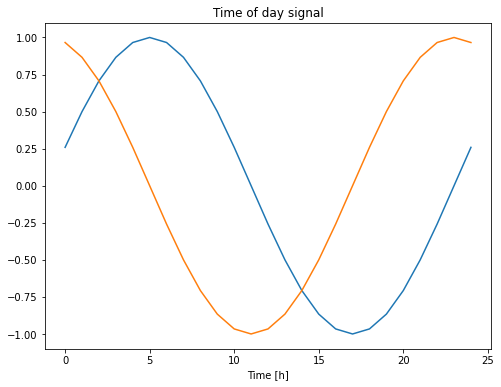

In [63]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Isso dá ao modelo acesso aos recursos de frequência mais importantes. Nesse caso, sabíamos com antecedência quais frequências eram importantes.

Se você não sabia, pode determinar quais frequências são importantes usando um fft. Para verificar nossas suposições, aqui está o tf.signal.rfft da temperatura ao longo do tempo. Observe os picos óbvios em frequências próximas a 1 / ano e 1 / dia:

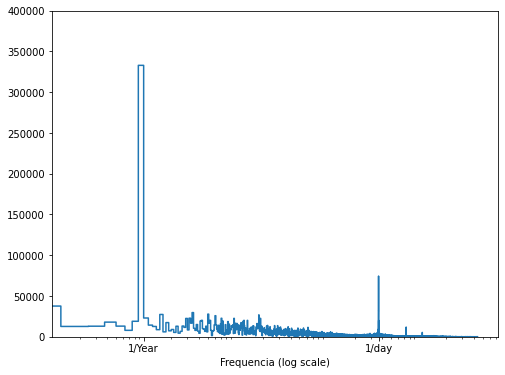

In [64]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequencia (log scale)')

### Dividir os dados 

Usaremos uma divisão (70%, 20%, 10%) para os conjuntos de treinamento, validação e teste. Observe que os dados não estão sendo misturados aleatoriamente antes da divisão. Isso é por duas razões.

1-Isso garante que dividir os dados em janelas de amostras consecutivas ainda seja possível.

2-Garante que os resultados da validação / teste sejam mais realistas, sendo avaliados nos dados coletados após o treinamento do modelo.

In [65]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normaliza os dados
É importante dimensionar recursos antes de treinar uma rede neural. A normalização é uma maneira comum de fazer esse dimensionamento. Subtraia a média e divida pelo desvio padrão de cada recurso.

A média e o desvio padrão só devem ser calculados usando os dados de treinamento para que os modelos não tenham acesso aos valores nos conjuntos de validação e teste.

Também é discutível que o modelo não deve ter acesso a valores futuros no conjunto de treinamento durante o treinamento, e que essa normalização deve ser feita usando médias móveis. Esse não é o foco deste tutorial, e os conjuntos de validação e teste garantem que obtenhamos métricas (de certa forma) honestas. Portanto, no interesse da simplicidade, este tutorial usa uma média simples.

In [66]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Agora dê uma olhada na distribuição dos recursos. Alguns recursos têm caudas longas, mas não há erros óbvios como o valor de velocidade do vento de -9999.

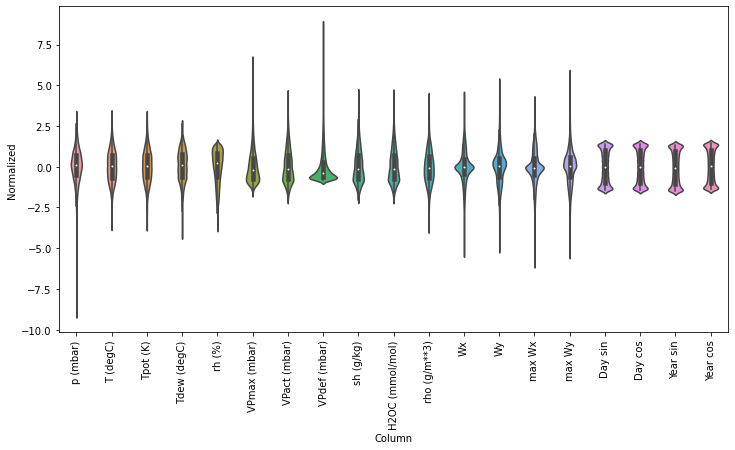

In [67]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### 1. Índices e deslocamentos

Comece criando a classe `WindowGenerator`. O método `__init__` inclui toda a lógica necessária para os índices de entrada e rótulo.

Ele também pega o trem, a avaliação e os dataframes de teste como entrada. Eles serão convertidos em `tf.data.Dataset`s do Windows posteriormente.

In [68]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Aqui está o código para criar as 2 janelas mostradas nos diagramas no início desta seção:

In [69]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [70]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Dividir
Dada uma lista de entradas consecutivas, o método `split_window` irá convertê-las em uma janela de entradas e uma janela de rótulos.




Este diagrama não mostra o eixo `features` dos dados, mas esta função` split_window` também lida com `label_columns` para que possa ser usada para exemplos de saída única e multi-saídas.

In [71]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [72]:
#Empilhe três fatias, o comprimento da janela total:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


### 3. Plot

Aqui está um método de plotagem que permite uma visualização simples da janela dividida:

In [73]:
w2.example = example_inputs, example_labels

In [74]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Este gráfico alinha entradas, rótulos e (mais tarde) previsões com base no tempo a que o item se refere:

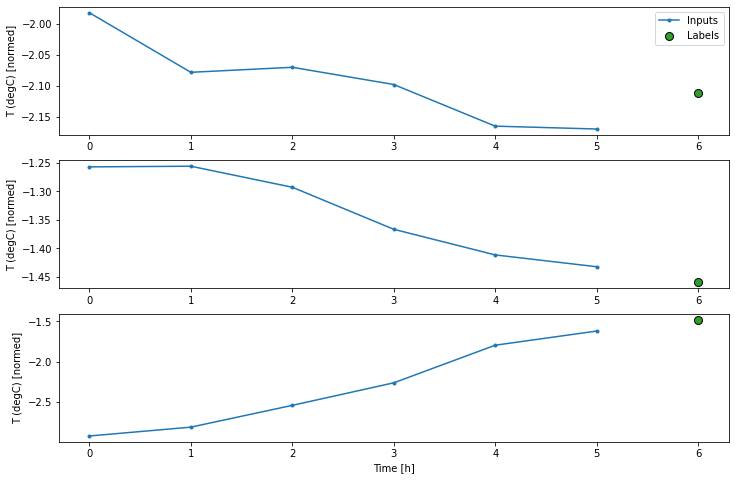

In [75]:
w2.plot()

Você pode plotar as outras colunas, mas a configuração w2 da janela de exemplo só tem rótulos para a coluna T (degC).

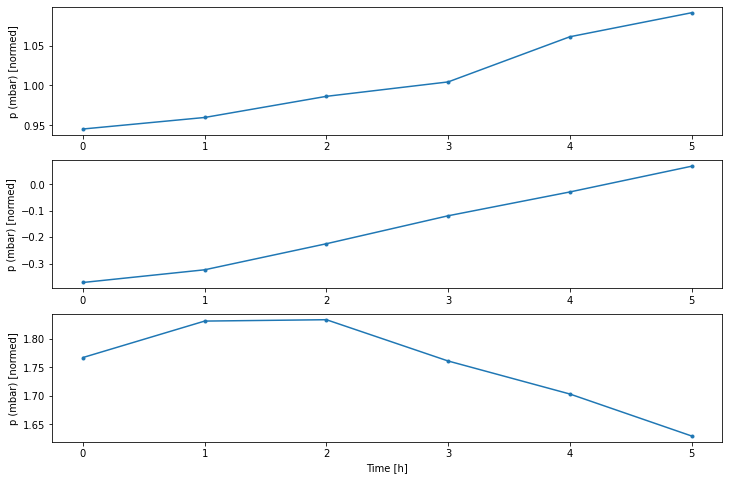

In [76]:
w2.plot(plot_col='p (mbar)')

### 4. Cria `tf.data.Dataset`s

Finalmente, este método make_dataset pegará um DataFrame de série temporal e o converterá em um tf.data.Dataset de pares (input_window, label_window) usando a função preprocessing.timeseries_dataset_from_array.

In [77]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

O objeto WindowGenerator contém dados de treinamento, validação e teste. Adicione propriedades para acessá-los como tf.data.Datasets usando o método make_dataset acima. Adicione também um lote de exemplo padrão para fácil acesso e plotagem:

In [78]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Agora, o objeto WindowGenerator fornece acesso aos objetos tf.data.Dataset, para que você possa iterar facilmente nos dados.

A propriedade Dataset.element_spec informa a estrutura, os tipos de dados e as formas dos elementos do conjunto de dados.

In [79]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

A iteração sobre um `Dataset` produz lotes concretos:

In [80]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Modelos de etapa única

O modelo mais simples que você pode construir neste tipo de dados é aquele que prevê o valor de um único recurso, 1 intervalo de tempo (1h) no futuro com base apenas nas condições atuais.

Portanto, comece construindo modelos para prever o valor `T (degC)` 1h no futuro.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure um objeto `WindowGenerator` para produzir esses pares` (entrada, rótulo) `de etapa única:

In [81]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

O objeto window cria tf.data.Datasets a partir dos conjuntos de treinamento, validação e teste, permitindo que você itere facilmente em lotes de dados.


In [82]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Linha de base

Antes de construir um modelo treinável, seria bom ter uma linha de base de desempenho como um ponto de comparação com os modelos posteriores mais complicados.

A primeira tarefa é prever a temperatura em 1h no futuro, considerando o valor atual de todos os recursos. Os valores atuais incluem a temperatura atual.

Portanto, comece com um modelo que apenas retorne a temperatura atual como a previsão, prevendo "Sem alteração". Esta é uma linha de base razoável, pois a temperatura muda lentamente. É claro que essa linha de base funcionará menos bem se você fizer uma previsão futura.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [83]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instancie e avalie este modelo:

In [84]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 3s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


Isso imprimiu algumas métricas de desempenho, mas elas não dão uma ideia de como o modelo está indo.

O WindowGenerator tem um método de plotagem, mas as plotagens não serão muito interessantes com apenas uma única amostra. Portanto, crie um WindowGenerator mais amplo que gere janelas 24h de entradas e rótulos consecutivos de uma vez.

O wide_window não muda a forma como o modelo opera. O modelo ainda faz previsões 1h no futuro com base em uma única etapa de tempo de entrada. Aqui, o eixo do tempo atua como o eixo do lote: cada previsão é feita de forma independente, sem interação entre as etapas de tempo.

In [85]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Esta janela expandida pode ser passada diretamente para o mesmo modelo de linha de base sem nenhuma alteração de código. Isso é possível porque as entradas e rótulos têm o mesmo número de passos de tempo, e a linha de base apenas encaminha a entrada para a saída:

  ![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [86]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


Traçando as previsões do modelo de linha de base, você pode ver que são simplesmente os rótulos, deslocados para a direita por 1h.

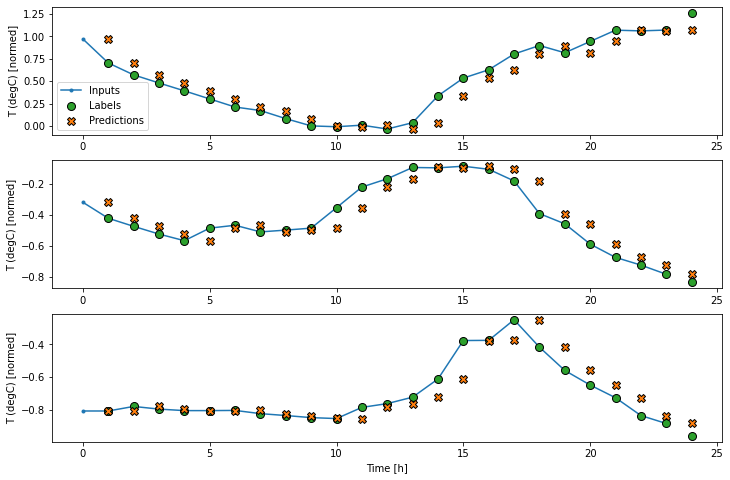

In [87]:
wide_window.plot(baseline)

Nos gráficos acima de três exemplos, o modelo de etapa única é executado ao longo de 24 horas. Isso merece alguma explicação:

* A linha azul "Entradas" mostra a temperatura de entrada em cada intervalo de tempo. O modelo recebe todas as características, este gráfico mostra apenas a temperatura.
* Os pontos verdes "Labels" mostram o valor de previsão de destino. Esses pontos são mostrados no tempo de previsão, não no tempo de entrada. É por isso que o intervalo de rótulos é deslocado 1 etapa em relação às entradas.
* As cruzes "Predições" em laranja são as previsões do modelo para cada intervalo de tempo de saída. Se o modelo previsse perfeitamente, as previsões pousariam diretamente nos "rótulos".

### Modelo Linear 

O modelo ** treinável ** mais simples que você pode aplicar a essa tarefa é inserir uma transformação linear entre a entrada e a saída. Neste caso, a saída de uma etapa de tempo depende apenas dessa etapa:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Um `camadas.Dense` sem conjunto de` ativação` é um modelo linear. A camada apenas transforma o último eixo dos dados de `(lote, tempo, entradas)` para `(lote, tempo, unidades)`, é aplicada independentemente a cada item nos eixos `lote` e` tempo`.

In [88]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [89]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


Este tutorial treina muitos modelos, portanto, empacote o procedimento de treinamento em uma função:

In [90]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Treine o modelo e avalie seu desempenho:

In [91]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 12s 7ms/step - loss: 0.5932 - mean_absolute_error: 0.3988 - val_loss: 0.0276 - val_mean_absolute_error: 0.1265
Epoch 2/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0199 - mean_absolute_error: 0.1049 - val_loss: 0.0120 - val_mean_absolute_error: 0.0806
Epoch 3/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0763 - val_loss: 0.0093 - val_mean_absolute_error: 0.0699
Epoch 4/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0094 - mean_absolute_error: 0.0709 - val_loss: 0.0088 - val_mean_absolute_error: 0.0685
Epoch 5/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684
Epoch 6/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.068

Como o modelo de linha de base, o modelo linear pode ser chamado em lotes de janelas largas. Usado dessa forma, o modelo faz um conjunto de previsões independentes em intervalos de tempo consecutivos. O eixo do tempo atua como outro eixo do lote. Não há interações entre as previsões em cada etapa de tempo.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [92]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Aqui está o gráfico de suas previsões de exemplo em wide_window, observe como em muitos casos a previsão é claramente melhor do que apenas retornar a temperatura de entrada, mas em alguns casos é pior:

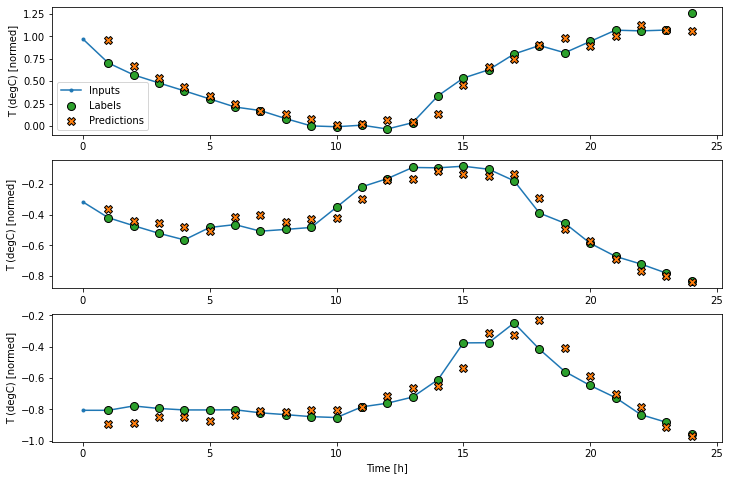

In [93]:
wide_window.plot(linear)

Uma vantagem dos modelos lineares é que eles são relativamente simples de interpretar.
Você pode retirar os pesos da camada e ver o peso atribuído a cada entrada:

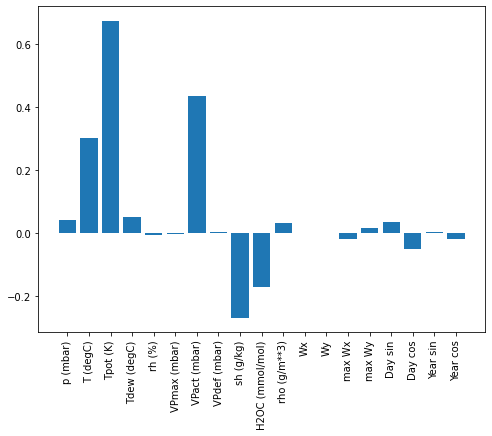

In [94]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Às vezes, o modelo nem mesmo coloca o maior peso na entrada T (degC). Este é um dos riscos da inicialização aleatória 

### Dense

Antes de aplicar modelos que realmente operam em várias etapas de tempo, vale a pena verificar o desempenho de modelos de etapa de entrada única mais profundos, mais poderosos.

Aqui está um modelo semelhante ao modelo linear, exceto que empilha várias camadas densas entre a entrada e a saída:

In [95]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0164 - mean_absolute_error: 0.0792 - val_loss: 0.0081 - val_mean_absolute_error: 0.0661
Epoch 2/20
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0077 - mean_absolute_error: 0.0636 - val_loss: 0.0076 - val_mean_absolute_error: 0.0630
Epoch 3/20
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0074 - mean_absolute_error: 0.0615 - val_loss: 0.0070 - val_mean_absolute_error: 0.0600
Epoch 4/20
1534/1534 [==============================] - 14s 9ms/step - loss: 0.0072 - mean_absolute_error: 0.0605 - val_loss: 0.0071 - val_mean_absolute_error: 0.0606
Epoch 5/20
439/439 [==============================] - 3s 6ms/step - loss: 0.0079 - mean_absolute_error: 0.0655


### Multi-step dense

Um modelo de passo único não tem contexto para os valores atuais de suas entradas. Ele não pode ver como os recursos de entrada estão mudando ao longo do tempo. Para resolver esse problema, o modelo precisa de acesso a várias etapas de tempo ao fazer previsões:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


Os modelos de linha de base, linear e denso trataram cada etapa de tempo independentemente. Aqui, o modelo levará várias etapas de tempo como entrada para produzir uma única saída.

Crie um WindowGenerator que produzirá lotes de 3h de entradas e 1h de rótulos:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [96]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

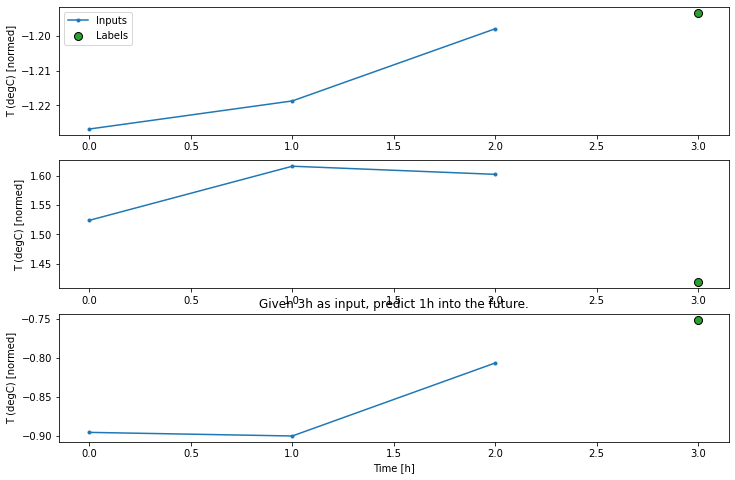

In [97]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

Você pode treinar um modelo denso em uma janela de várias etapas de entrada adicionando uma camada. Plano como a primeira camada do modelo:

In [98]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [99]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [100]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 3s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0698


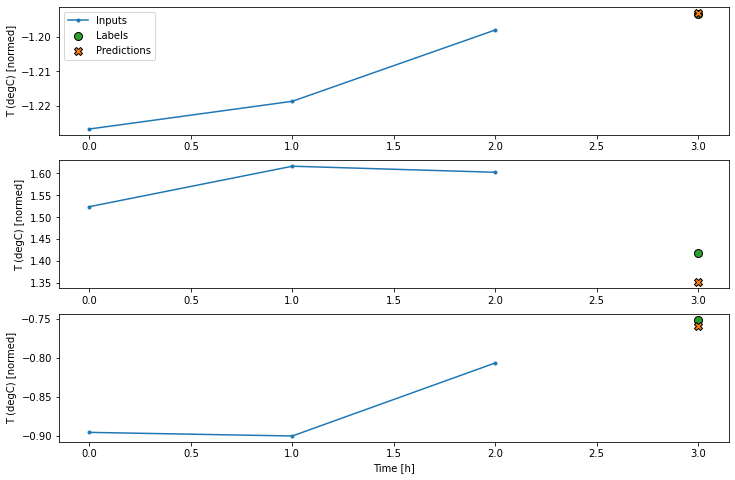

In [101]:
conv_window.plot(multi_step_dense)

A principal desvantagem dessa abordagem é que o modelo resultante só pode ser executado em janelas de entrada exatamente desta forma.

In [102]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_3" (type Sequential).

Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1of input shape to have value 57, but received input with shape (32, 456)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


Os modelos convolucionais na próxima seção corrigem esse problema.

### Rede Neural Convolucional
 
Uma camada de convolução (`layers.Conv1D`) também leva várias etapas de tempo como entrada para cada previsão.

Abaixo está o ** mesmo ** modelo de `multi_step_dense`, reescrito com uma convolução.

Observe as mudanças:
* O `layers.Flatten` e o primeiro` layers.Dense` são substituídos por um `layers.Conv1D`.
* O `layers.Reshape` não é mais necessário, pois a convolução mantém o eixo do tempo em sua saída.

In [103]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Execute-o em um lote de exemplo para ver se o modelo produz resultados com a forma esperada:

In [104]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Treine e avalie-o no conv_window e ele deve ter um desempenho semelhante ao modelo multi_step_dense.

In [105]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 3s 6ms/step - loss: 0.0078 - mean_absolute_error: 0.0663


A diferença entre este conv_model e o modelo multi_step_dense é que o conv_model pode ser executado em entradas de qualquer comprimento. A camada convolucional é aplicada a uma janela deslizante de entradas:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

Se você executá-lo com uma entrada mais ampla, ele produz uma saída mais ampla:

In [106]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Observe que a saída é mais curta do que a entrada. Para fazer o treinamento ou a plotagem funcionar, você precisa que os rótulos e a previsão tenham a mesma duração. Portanto, crie um WindowGenerator para produzir janelas amplas com algumas etapas extras de tempo de entrada para que o rótulo e os comprimentos de previsão correspondam:

In [107]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [108]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Agora você pode representar graficamente as previsões do modelo em uma janela mais ampla. Observe as 3 etapas de tempo de entrada antes da primeira previsão. Cada previsão aqui é baseada nos 3 passos de tempo anteriores:

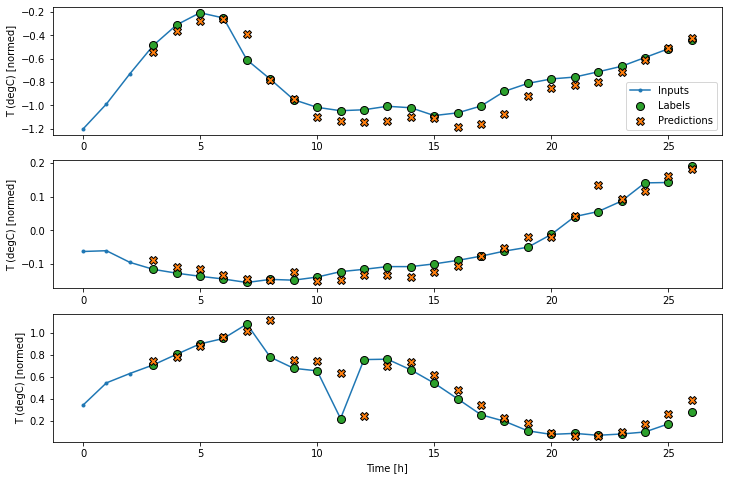

In [109]:
wide_conv_window.plot(conv_model)

### Rede Neural Recorrente 

Uma Rede Neural Recorrente (RNN) é um tipo de rede neural adequada para dados de série temporal. Os RNNs processam uma série temporal passo a passo, mantendo um estado interno passo a passo.

para mais detalhes [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) ou [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

Neste tutorial, você usará uma camada RNN chamada Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

Um argumento construtor importante para todas as camadas RNN keras é o argumento `return_sequences`. Essa configuração pode configurar a camada de duas maneiras.

1. Se `False`, o padrão, a camada retorna apenas a saída do passo de tempo final, dando ao modelo tempo para aquecer seu estado interno antes de fazer uma única previsão:

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. Se for True, a camada retorna uma saída para cada entrada. Isso é útil para:
* Empilhando camadas RNN.
* Treinar um modelo em vários passos de tempo simultaneamente.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [110]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Com return_sequences = True, o modelo pode ser treinado em 24 horas de dados por vez.

Nota: Isso dará uma visão pessimista do desempenho do modelo. No primeiro passo de tempo, o modelo não tem acesso às etapas anteriores e, portanto, não pode fazer melhor do que os modelos lineares e densos simples mostrados anteriormente.

In [111]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [112]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 3s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0511


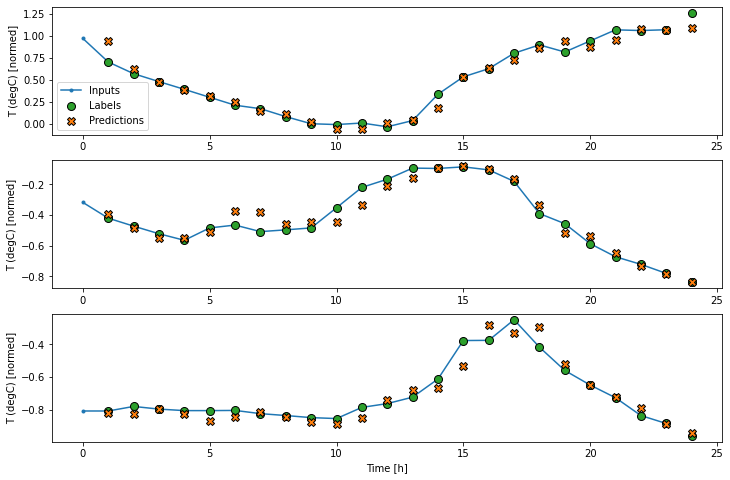

In [113]:
wide_window.plot(lstm_model)

### Performance

Com esse conjunto de dados, normalmente cada um dos modelos se sai um pouco melhor do que o anterior.

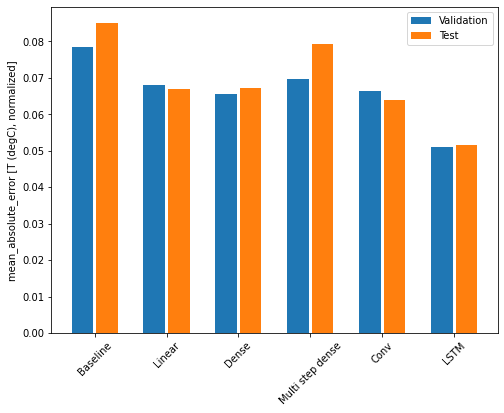

In [114]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [115]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0669
Dense       : 0.0672
Multi step dense: 0.0794
Conv        : 0.0640
LSTM        : 0.0516


### Multi-Saidas Modelos

Os modelos até agora previram um único recurso de saída, T (degC), para uma única etapa de tempo.

Todos esses modelos podem ser convertidos para prever vários recursos apenas alterando o número de unidades na camada de saída e ajustando as janelas de treinamento para incluir todos os recursos nos rótulos.


In [116]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Observe acima que o eixo dos recursos dos rótulos agora tem a mesma profundidade que as entradas, em vez de 1.

#### Baseline

O mesmo modelo de linha de base pode ser usado aqui, mas desta vez repetindo todos os recursos em vez de selecionar um `label_index` específico.

In [117]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [118]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 3s 5ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [119]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [120]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 3s 6ms/step - loss: 0.0688 - mean_absolute_error: 0.1305


#### RNN


In [121]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 3s 7ms/step - loss: 0.0618 - mean_absolute_error: 0.1207

CPU times: user 4min 35s, sys: 42.7 s, total: 5min 17s
Wall time: 4min 6s


<a id="residual"></a>

#### Advanced: Residual connections

O modelo `Baseline` anterior aproveitou o fato de que a sequência não muda drasticamente de uma etapa de tempo para outra. Cada modelo treinado neste tutorial até agora foi inicializado aleatoriamente e, em seguida, teve que aprender que a saída é uma pequena mudança em relação ao intervalo de tempo anterior.

Embora você possa contornar esse problema com uma inicialização cuidadosa, é mais simples construir isso na estrutura do modelo.

É comum na análise de série temporal construir modelos que, em vez de prever o próximo valor, prevejam como o valor mudará no próximo passo de tempo.
Da mesma forma, "Redes residuais" ou "ResNets" no aprendizado profundo referem-se a arquiteturas em que cada camada é adicionada ao resultado acumulado do modelo.

É assim que você aproveita o conhecimento de que a mudança deve ser pequena.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essencialmente, isso inicializa o modelo para corresponder à `Linha de base`. Para essa tarefa, ajuda os modelos a convergirem mais rapidamente, com desempenho um pouco melhor.

Essa abordagem pode ser usada em conjunto com qualquer modelo discutido neste tutorial.

Aqui está sendo aplicado ao modelo LSTM, observe o uso de `tf.initializers.zeros` para garantir que as mudanças iniciais previstas sejam pequenas e não superem a conexão residual. Não há problemas de quebra de simetria para os gradientes aqui, uma vez que os `zeros` são usados apenas na última camada.

In [122]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [123]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 3s 7ms/step - loss: 0.0621 - mean_absolute_error: 0.1176

CPU times: user 2min 11s, sys: 20.1 s, total: 2min 31s
Wall time: 1min 49s


#### Performance

Aqui está o desempenho geral para esses modelos de múltiplas saídas

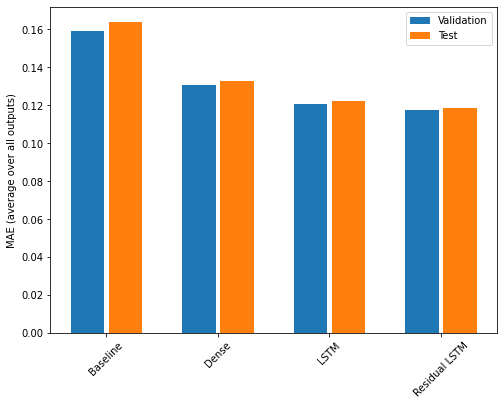

In [124]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [125]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1326
LSTM           : 0.1221
Residual LSTM  : 0.1188


Os desempenhos acima são a média de todos os resultados do modelo.

## Modelos multi-etapas

Os modelos de saída única e de saída múltipla nas seções anteriores fizeram ** previsões de passo único **, 1h no futuro.

Esta seção examina como expandir esses modelos para fazer ** previsões de várias etapas de tempo **.

Em uma previsão de várias etapas, o modelo precisa aprender a prever uma gama de valores futuros. Assim, ao contrário de um modelo de etapa única, onde apenas um único ponto futuro é previsto, um modelo de várias etapas prevê uma sequência dos valores futuros.

Existem duas abordagens básicas para isso:

1. Previsões de disparo único em que toda a série temporal é prevista de uma só vez.
2. Predições autorregressivas em que o modelo só faz predições de etapa única e sua saída é realimentada como entrada.

Nesta seção, todos os modelos irão prever ** todos os recursos em todas as etapas de tempo de saída **.


Para o modelo de várias etapas, os dados de treinamento consistem novamente em amostras por hora. Porém, aqui, os modelos aprenderão a prever 24h do futuro, dadas 24h do passado.

Aqui está um objeto `Window` que gera essas fatias do conjunto de dados:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

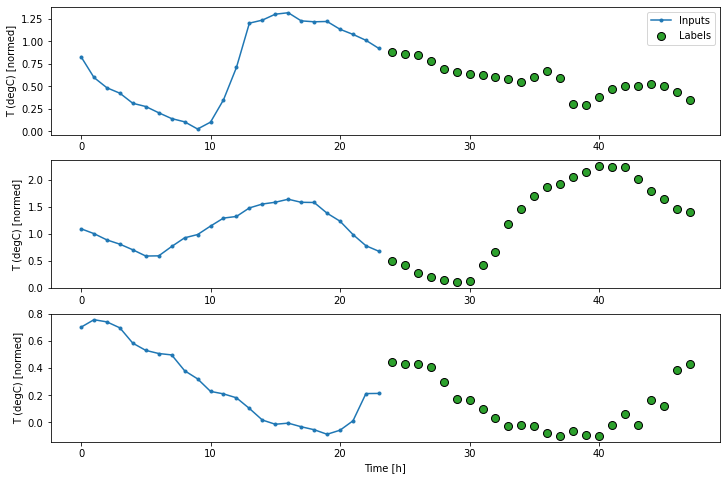

In [126]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

Uma linha de base simples para esta tarefa é repetir a última etapa de tempo de entrada para o número necessário de passos de tempo de saída:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

437/437 [==============================] - 3s 6ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


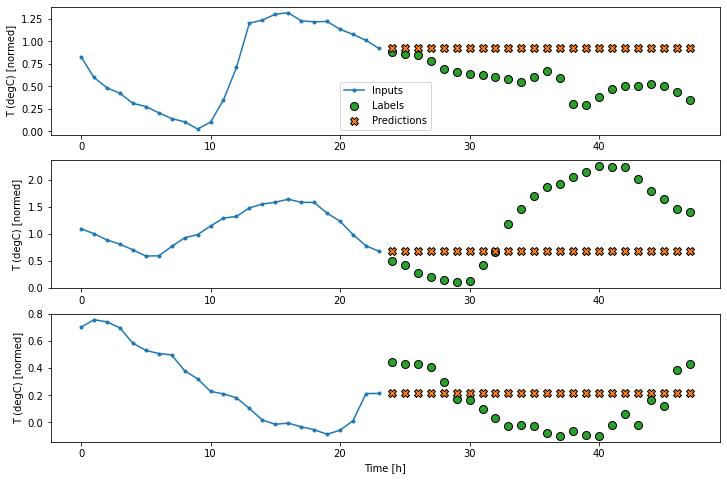

In [127]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Uma linha de base simples para esta tarefa é repetir na última etapa de tempo de entrada para o número necessário de passos de tempo de saída:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

437/437 [==============================] - 3s 6ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


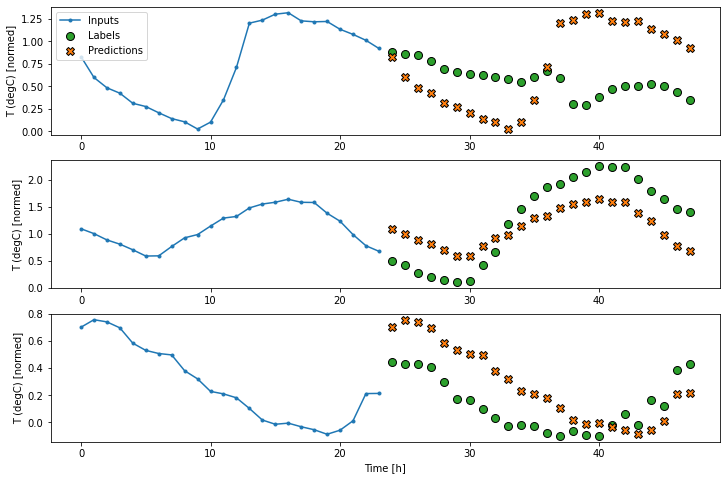

In [128]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Modelos single-shot

Uma abordagem de alto nível para este problema é usar um modelo "single-shot", onde o modelo faz a predição de sequência inteira em uma única etapa.

Isso pode ser implementado de forma eficiente como um `layers.Dense` com unidades de saída` OUT_STEPS * features`. O modelo só precisa remodelar a saída para o `(OUTPUT_STEPS, recursos)` necessário.

#### Linear

Um modelo linear simples com base na última etapa de tempo de entrada se sai melhor do que qualquer linha de base, mas tem potência insuficiente. O modelo precisa prever etapas de tempo `OUTPUT_STEPS`, a partir de uma única etapa de tempo de entrada com uma projeção linear. Ele pode capturar apenas uma fatia de baixa dimensão do comportamento, provavelmente com base principalmente na hora do dia e na época do ano.

![Predct all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

437/437 [==============================] - 3s 6ms/step - loss: 0.2563 - mean_absolute_error: 0.3057


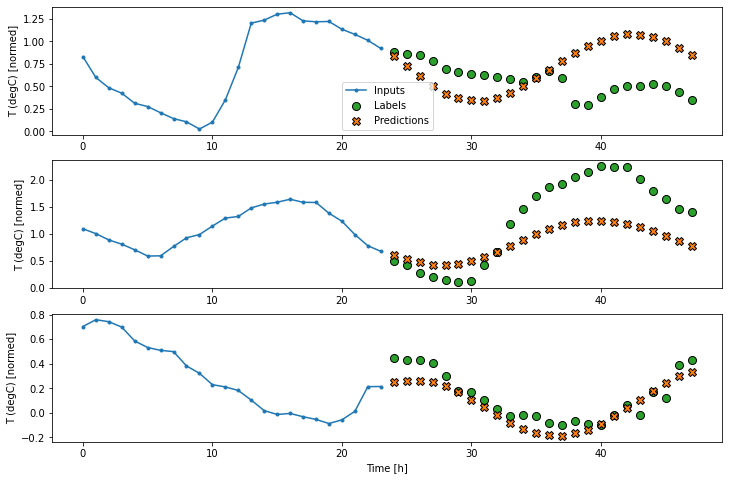

In [129]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adicionar um `layers.Dense` entre a entrada e a saída dá ao modelo linear mais poder, mas ainda é baseado apenas em um único passo de tempo de entrada.

437/437 [==============================] - 3s 6ms/step - loss: 0.2214 - mean_absolute_error: 0.2841


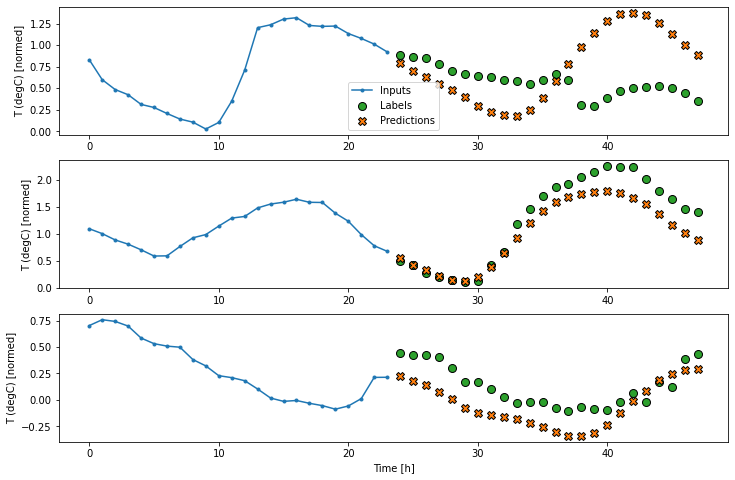

In [130]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Um modelo convolucional faz previsões com base em um histórico de largura fixa, o que pode levar a um melhor desempenho do que o modelo denso, pois pode ver como as coisas estão mudando ao longo do tempo:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

437/437 [==============================] - 3s 6ms/step - loss: 0.2143 - mean_absolute_error: 0.2814


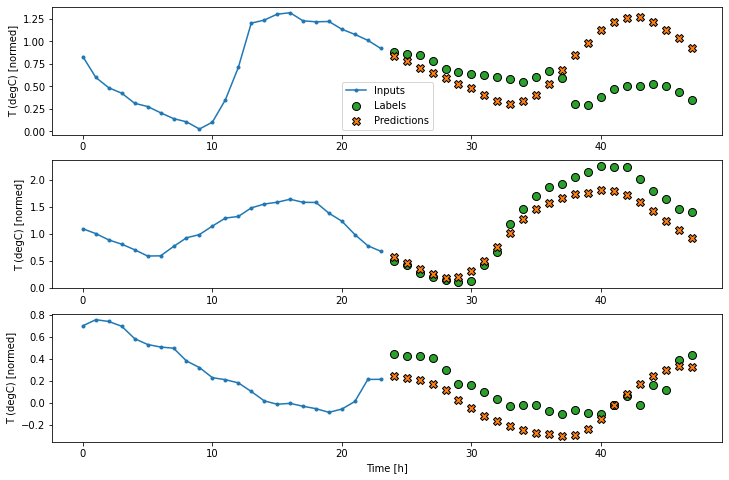

In [131]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

Um modelo recorrente pode aprender a usar um longo histórico de entradas, se for relevante para as previsões que o modelo está fazendo. Aqui, o modelo acumulará o estado interno por 24h, antes de fazer uma única previsão para as próximas 24h.

Neste formato de disparo único, o LSTM só precisa produzir uma saída na última etapa de tempo, então defina `return_sequences = False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


437/437 [==============================] - 3s 7ms/step - loss: 0.2139 - mean_absolute_error: 0.2847


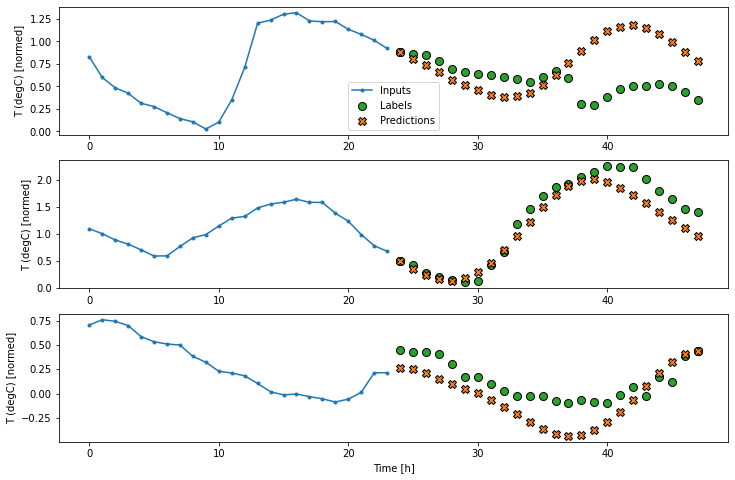

In [132]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Avançado: modelo autorregressivo

Todos os modelos acima prevêem toda a sequência de saída em uma única etapa.

Em alguns casos, pode ser útil para o modelo decompor essa previsão em etapas de tempo individuais. Em seguida, a saída de cada modelo pode ser realimentada em cada etapa e as previsões podem ser feitas condicionadas na anterior, como no clássico [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

Uma vantagem clara desse estilo de modelo é que ele pode ser configurado para produzir saídas com comprimento variável.

Você poderia pegar qualquer um dos modelos de múltiplas saídas de etapa única treinados na primeira metade deste tutorial e executar em um loop de feedback autoregressivo, mas aqui nos concentraremos na construção de um modelo que foi explicitamente treinado para fazer isso.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)


#### RNN

Este tutorial constrói apenas um modelo RNN autoregressivo, mas esse padrão pode ser aplicado a qualquer modelo que foi projetado para produzir um único passo de tempo.

O modelo terá a mesma forma básica dos modelos `LSTM` de etapa única: Um` LSTM` seguido por um `layers.Dense` que converte as saídas` LSTM` em previsões do modelo.

Um `layers.LSTM` é um` layers.LSTMCell` envolto no nível superior `layers.RNN` que gerencia os resultados de estado e sequência para você (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

Neste caso, o modelo deve gerenciar manualmente as entradas para cada etapa, de modo que use `camadas.LSTMCell` diretamente para o nível inferior, interface de etapa única de tempo.

In [133]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [134]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

O primeiro método de que esse modelo precisa é um método de aquecimento para inicializar seu estado interno com base nas entradas. Depois de treinado, esse estado irá capturar as partes relevantes do histórico de entrada. Isso é equivalente ao modelo LSTM de etapa única anterior:

In [135]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Este método retorna uma única predição de intervalo de tempo e o estado interno do LSTM:

In [136]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Com o estado do `RNN` e uma predição inicial, agora você pode continuar iterando o modelo, alimentando as predições a cada passo para trás como entrada.

A abordagem mais simples para coletar as previsões de saída é usar uma lista python e `tf.stack` após o loop.

Nota: Empilhar uma lista python como esta só funciona com execução antecipada, usando `Model.compile (..., run_eagerly = True)` para treinamento, ou com uma saída de comprimento fixo. Para um comprimento de saída dinâmico, você precisaria usar um `tf.TensorArray` ao invés de uma lista python, e` tf.range` ao invés do `range` python.

In [137]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Teste a execução deste modelo nas entradas de exemplo:

In [138]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Agora treine o modelo:

437/437 [==============================] - 7s 15ms/step - loss: 0.2274 - mean_absolute_error: 0.3040


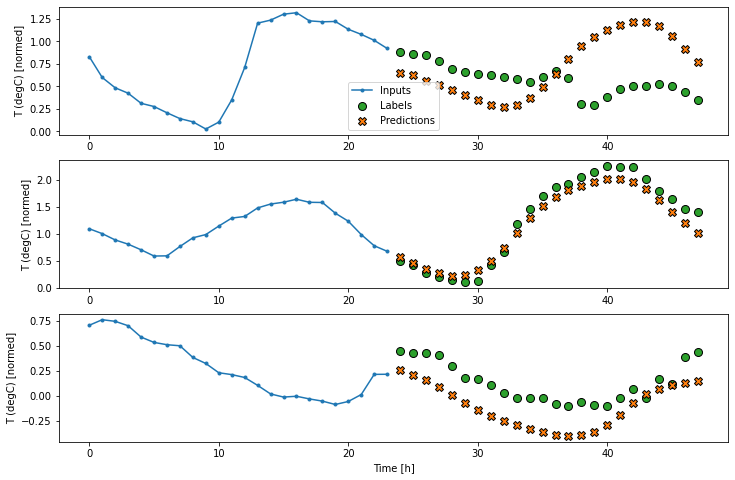

In [139]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

Existem retornos claramente decrescentes em função da complexidade do modelo neste problema

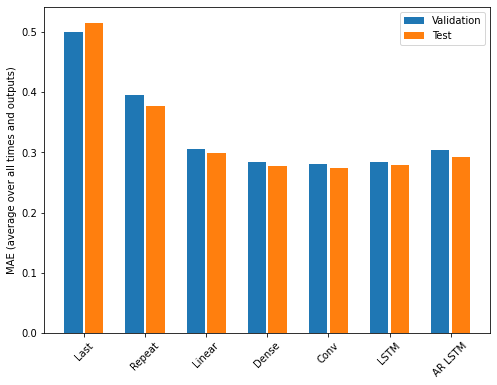

In [140]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

As métricas para os modelos de múltiplas saídas na primeira metade deste tutorial mostram o desempenho médio em todos os recursos de saída. Esses desempenhos são semelhantes, mas também são calculados em média entre os passos de tempo de saída.

In [141]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2983
Dense   : 0.2782
Conv    : 0.2739
LSTM    : 0.2785
AR LSTM : 0.2927


Os ganhos alcançados indo de um modelo denso para modelos convolucionais e recorrentes são apenas alguns por cento (se houver), e o modelo autoregressivo teve um desempenho claramente pior. Portanto, essas abordagens mais complexas podem não valer a pena neste  problema , mas não havia como saber sem tentar, e esses modelos poderiam ser úteis para seu  problema.